# Exploration of the Data and Results

In [2]:
from __future__ import annotations
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

sns.set()
sns.set_style('whitegrid')

## Data Exploration

In [3]:
from enum import Enum, auto
class Caso(Enum):
    TEST = auto()
    TRAIN = auto()
    
class Language(Enum):
    ESP = auto()
    ENG = auto()

In [4]:
data_path = Path("data/public_data/")
if not data_path.exists():
    raise FileNotFoundError("No se encuentra el directorio con los datos")
train_path = Path(data_path / "SatiSPeech_phase_2_train_public.csv")
test_path = Path(data_path / "SatiSPeech_phase_2_test_public.csv")
fig_path = Path("WorkingNotes/figures/")
fig_path.mkdir(exist_ok=True)
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df

,id,label,transcription
0,5eef381b-7c3102ad.mp3,satire,"Yo creo que ya lo dice la propia frase, es pri..."
1,3db0b886-434a22fd.mp3,no-satire,"El presidente de Estados Unidos, Barack Obama,..."
2,1e3fd1a7-dfd534d8.mp3,satire,El presidente Andrés Manuel López Obrador visi...
3,2f593981-4087fa79.mp3,satire,"La sedición, porque inflación puede haber en c..."
4,815c0b94-1002ecaa.mp3,no-satire,Frenar la escalada de violencia en Gaza es una...
...,...,...,...
5995,3982793b-e3c0ec4a.mp3,no-satire,Pero la oficina del presidente francés dice qu...
5996,f0442261-0348093a.mp3,satire,No sé cómo se dice en castellano. Está siendo ...
5997,64ea7bec-c46cfd71.mp3,no-satire,"Sí, porque Rajoy dice que la razón de que esa ..."
5998,59a76f7b-75cc8d14.mp3,no-satire,Francisco era conocido como Jimmy entre los se...


In [5]:
label_counts = df['label'].value_counts(normalize=True) * 100
labels = label_counts.index
percentages = label_counts.values

In [6]:
def plot_label_distribution_percentage(df, lan: Language, caso: Caso = Caso.TRAIN, ax=None):
    df = df.copy()
    label_counts = df['label'].value_counts(normalize=True) * 100
    labels = label_counts.index
    percentages = label_counts.values

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    sns.barplot(x=labels, y=percentages, palette='pastel', ax=ax)
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = 'Distribución porcentual de etiquetas (entrenamiento)'
        else:
            title = 'Distribución de la longitud de las transcripciones (test)'
        xlab = 'Etiqueta'
        ylab = 'Porcentaje (%)'
    else:
        if caso == Caso.TRAIN:
            title = 'Label distribution (training)'
        else:
            title = 'Label distribution (test)'
        xlab = 'Label'
        ylab = 'Percentage (%)'

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.set_ylim(0, 100)

    for i, p in enumerate(ax.patches):
        height = p.get_height() # type: ignore
        if height > 1:
            ax.text(p.get_x() + p.get_width()/2., height + 1, # type: ignore
                    f'{height:.2f}%', ha="center", fontsize=11)

    return ax

Añadimos el path de los audios

In [7]:
df["path"] = df["id"].apply(lambda x: f"{data_path}/segments_train/{x}")
df_test["path"] = df_test["uid"].apply(lambda x: f"{data_path}/segments_test/{x}")
df_test.head()

,uid,transcription,path
0,fa8196b4-166b7bb9.mp3,La Comunidad de Madrid hace frente así a la sa...,data/public_data/segments_test/fa8196b4-166b7b...
1,b407b2e7-63887829.mp3,Los féretros han sido trasladados a Chiclana y...,data/public_data/segments_test/b407b2e7-638878...
2,91cfff91-f54d3c31.mp3,"Esto que parece una obviedad, ser contundentes...",data/public_data/segments_test/91cfff91-f54d3c...
3,27e25c21-1cf4072b.mp3,Usted mismo reconoce que cada vez se parece má...,data/public_data/segments_test/27e25c21-1cf407...
4,bb4ddfe5-fe837a69.mp3,Vamos a escuchar a todos los miembros del Comi...,data/public_data/segments_test/bb4ddfe5-fe837a...


In [8]:
def plot_distr_palabras(df, caso: Caso, lan: Language, ax=None):
    df = df.copy()
    df["n_palabras"] = df["transcription"].apply(lambda x: len(str(x).split()))
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4))
    sns.histplot(
        data=df,
        x="n_palabras",
        hue= None if caso == Caso.TEST else "label",
        bins=40,
        kde=True,
        element="step",
        ax=ax,
    )
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = "Distribución de la longitud de las transcripciones (entrenamiento)"
        else:
            title = "Distribución de la longitud de las transcripciones (test)"
        xlab = "Número de palabras por transcripción"
        ylab = "Frecuencia"
    else:
        if caso == Caso.TRAIN:
            title = "Transcription length distribution (training)"
        else:
            title = "Transcription length distribution (test)"
        xlab = "Words per transcription"
        ylab = "Frequency"
    ax.set_xlim(0,150)
    if ax.legend_ is not None:
        ax.legend_.set_title(None) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return ax

In [9]:
def plot_distr_audio(df, caso: Caso, lan: Language, ax=None):
    df = df.copy()
    df["duration"] = df["path"].apply(lambda p: librosa.get_duration(path=p))

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4))
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = "Duración de los audios (entrenamiento)"
        else:
            title = "Duración de los audios (test)"
        xlab = "Duración (s)"
        ylab = "Frecuencia"
    else:
        if caso == Caso.TRAIN:
            title = "Audio duration (training)"
        else:
            title = "Audio duration (test)"
        xlab = "Duration (s)"
        ylab = "Frequency"
    sns.histplot(
        data=df,
        x="duration",
        hue= None if caso == Caso.TEST else "label",
        bins=40,
        kde=True,
        element="step",
        ax=ax,
    )
    ax.set_xlim(10,25)
    if ax.legend_ is not None:
        ax.legend_.set_title(None) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return ax

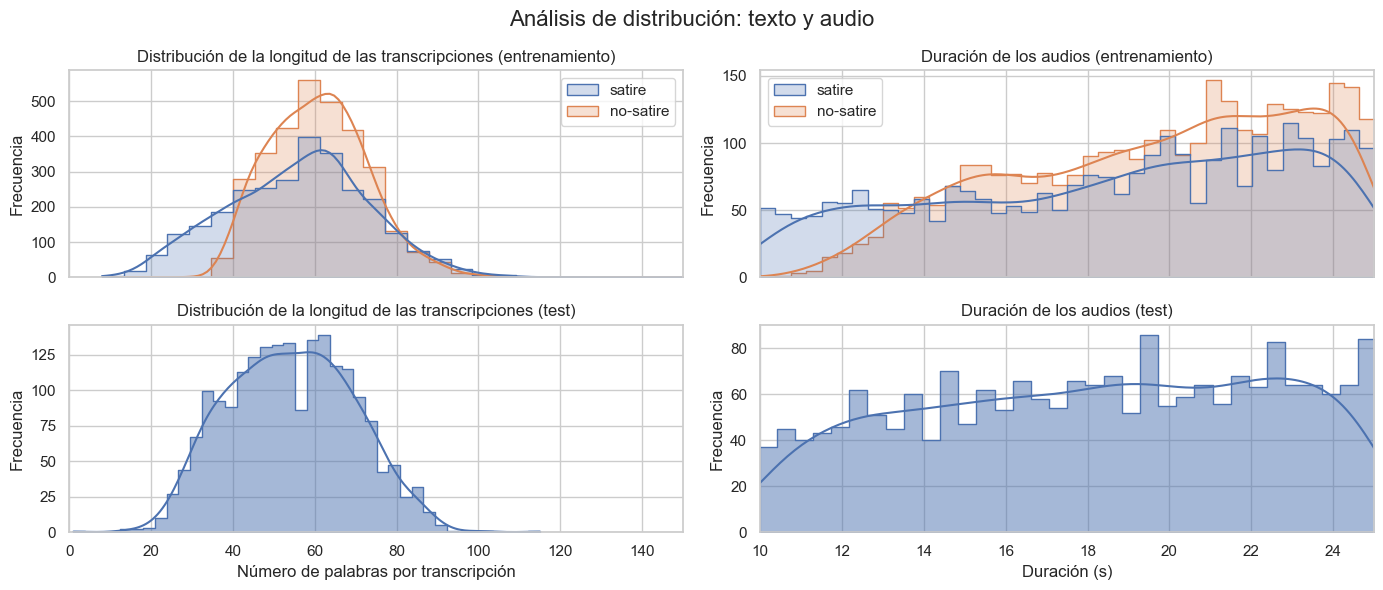

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex='col')

plot_distr_palabras(df, caso = Caso.TRAIN, lan = Language.ESP, ax=axes[0][0])
plot_distr_audio(df, caso = Caso.TRAIN, lan = Language.ESP, ax=axes[0][1])
plot_distr_palabras(df_test, caso = Caso.TEST, lan = Language.ESP, ax=axes[1][0])
plot_distr_audio(df_test, caso = Caso.TEST, lan = Language.ESP, ax=axes[1][1])

fig.suptitle('Análisis de distribución: texto y audio', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)  # deja espacio para el título
plt.show()

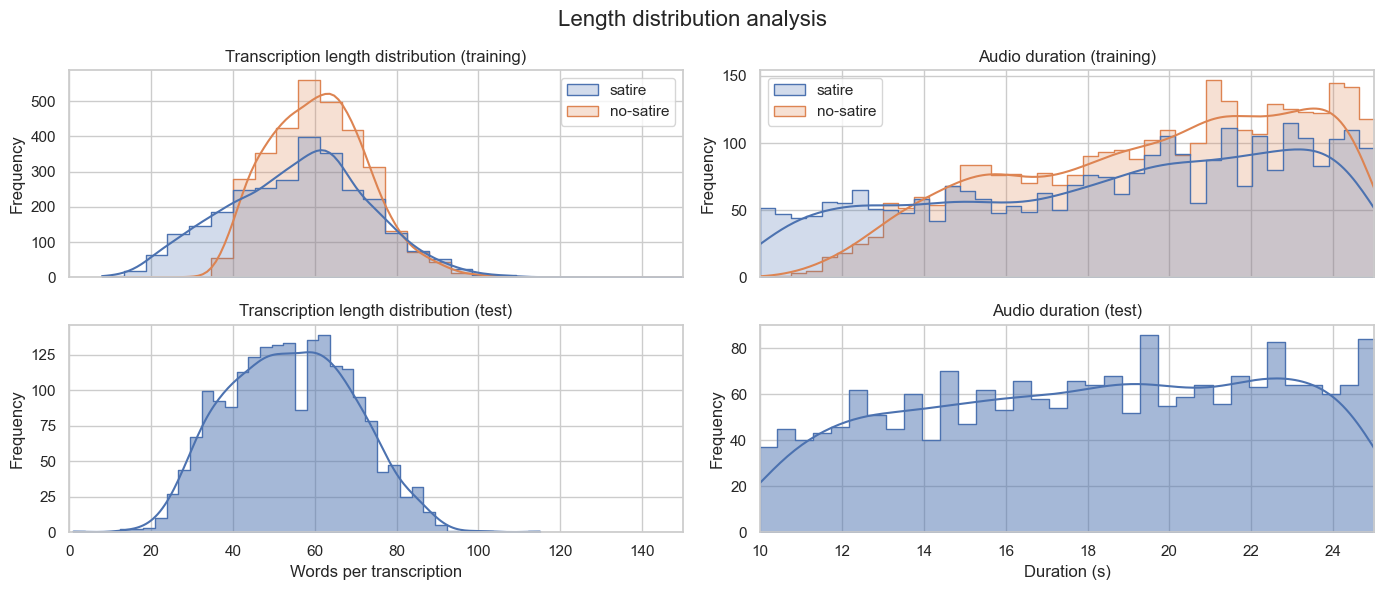

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex='col')
lan = Language.ENG

plot_distr_palabras(df, caso = Caso.TRAIN, lan = lan, ax=axes[0][0])
plot_distr_audio(df, caso = Caso.TRAIN, lan = lan, ax=axes[0][1])
plot_distr_palabras(df_test, caso = Caso.TEST, lan = lan, ax=axes[1][0])
plot_distr_audio(df_test, caso = Caso.TEST, lan = lan, ax=axes[1][1])

fig.suptitle('Length distribution analysis', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)  
fig.savefig(fig_path/"duration_distribution.png", dpi = 300)
plt.show()

## Result exploration

In [47]:
import json
from typing import Optional
from dataclasses import dataclass

beautify_map = {
    "roberta": "RoBERTa",
    "fasttext": "FastText",
    "word2vec": "Word2Vec",
    "hubert": "HuBERT",
    "w2v2": "Wav2Vec2",
    "cls": "CLS",
    "mean": "Mean",
    "mfcc": "MFCC",
}

@dataclass
class Result:
    """ 
    Result of a single experiment.
    The class also provides static methods to load all the results from a directory or a JSON file.
    """
    name: str
    type: str
    fusion: Optional[str]
    model: str
    f1score: float
    
    @staticmethod
    def from_json(filepath: Path, beautify_name: bool = True) -> list[Result]:
        rs: list[Result] = []
        name: str
        type = filepath.parent.name
        if type == "combi":
            name = "+".join(filepath.stem.split("+")[:-1])
            fusion = filepath.stem.split("+")[-1] 
        else:
            name = filepath.stem
            fusion = None
        if beautify_name:
            for k,v in beautify_map.items():
                name = name.replace(k,v)
        with open(filepath) as f:
            results = json.load(f)
            for model, result in results.items():
                f1score = result["macro avg"]["f1-score"]
                rs.append(Result(name, type, fusion, model, f1score))
        return rs
    
    @staticmethod
    def from_dir(dirpath: Path) -> list[Result]:
        rs: list[Result] = []
        for f in dirpath.glob("**/*.json"):
            rs.extend(Result.from_json(f))
        return rs
    
    @staticmethod
    def get_df(results: list[Result]) -> pd.DataFrame:
        return pd.DataFrame([r.__dict__ for r in results])

In [ ]:
from matplotlib.axes import Axes
def plot_f1_overview(
    df: pd.DataFrame,
    title_str: str = "",
    figsize: Optional[tuple[int, int]] = (10, 6),
    xticks_rotation: int = 0,
    ax: Optional[Axes] = None,
    hue_order: Optional[list[str]] = None,
) -> Axes:
    if hue_order is None:
        hue_order = ["DNN", "SVM" , "LogisticRegression"]
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        df,
        x="name",
        y="f1score",
        hue="model",
        hue_order=hue_order,
        ax=ax,
    )
    ax.set_ylim(0.7, 1)
    ax.set_ylabel("Macro F1-Score")
    ax.set_xlabel("")
    if xticks_rotation != 0:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=xticks_rotation, ha="right")
    ax.set_title(title_str, fontsize=14)
    ax.get_legend().set_title("")
    return ax

In [155]:
combi = Result.get_df(Result.from_dir(Path("results/combi")))
audio = Result.get_df(Result.from_dir(Path("results/audio")))
text = Result.get_df(Result.from_dir(Path("results/text")))

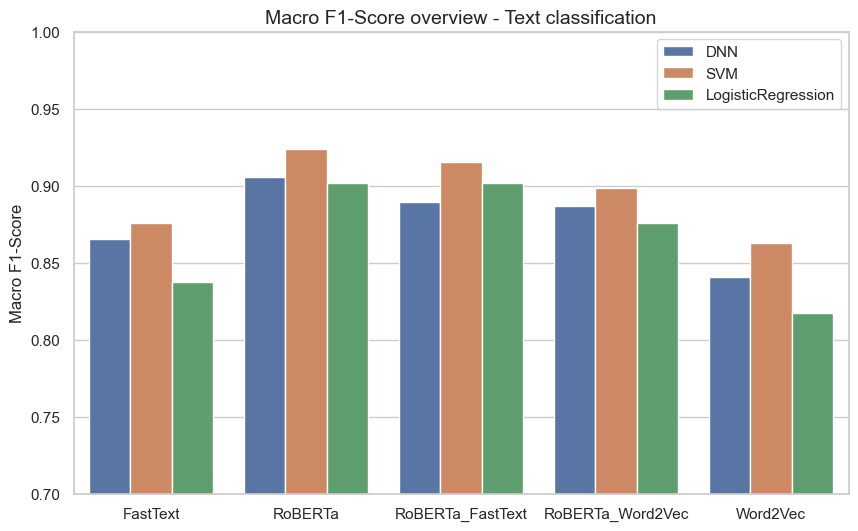

In [133]:
plot = plot_f1_overview(
    text[text.model != "RandomForest"].sort_values("name"),
    "Macro F1-Score overview - Text classification",
)
plt.savefig("./WorkingNotes/figures/mono_text.png", dpi=300)
plt.show()

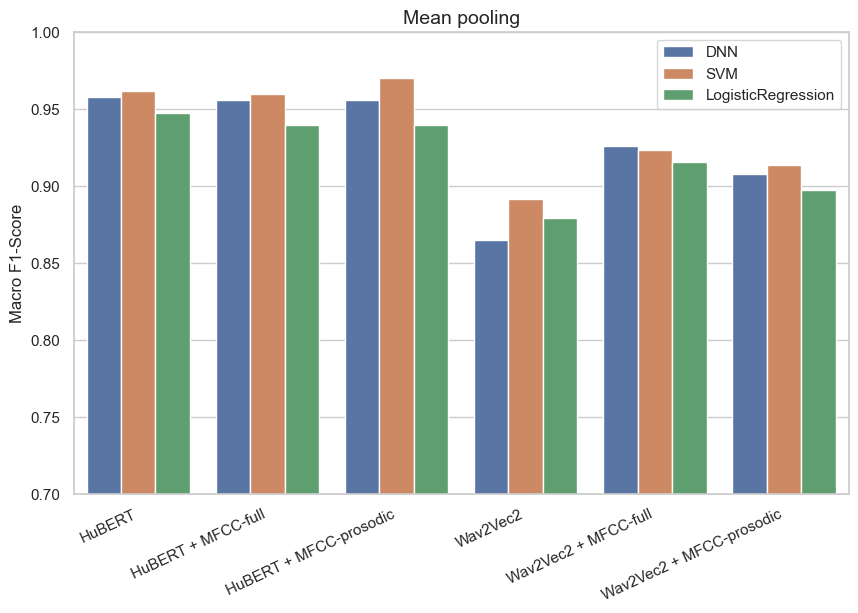

In [113]:
plot_f1_overview(
    audio[(audio.name.str.contains("-mean", case=False)) &
          (~audio.name.str.contains("-stats", case=False)) &
          (audio.model != "RandomForest")]
        .apply(lambda x: x.str.replace("-Mean", "") if x.name == "name" else x)
        .apply(lambda x: x.str.replace("_", " + ") if x.name == "name" else x)
        .sort_values("name"),
    "Mean pooling",
    xticks_rotation=25,
)
plt.show()

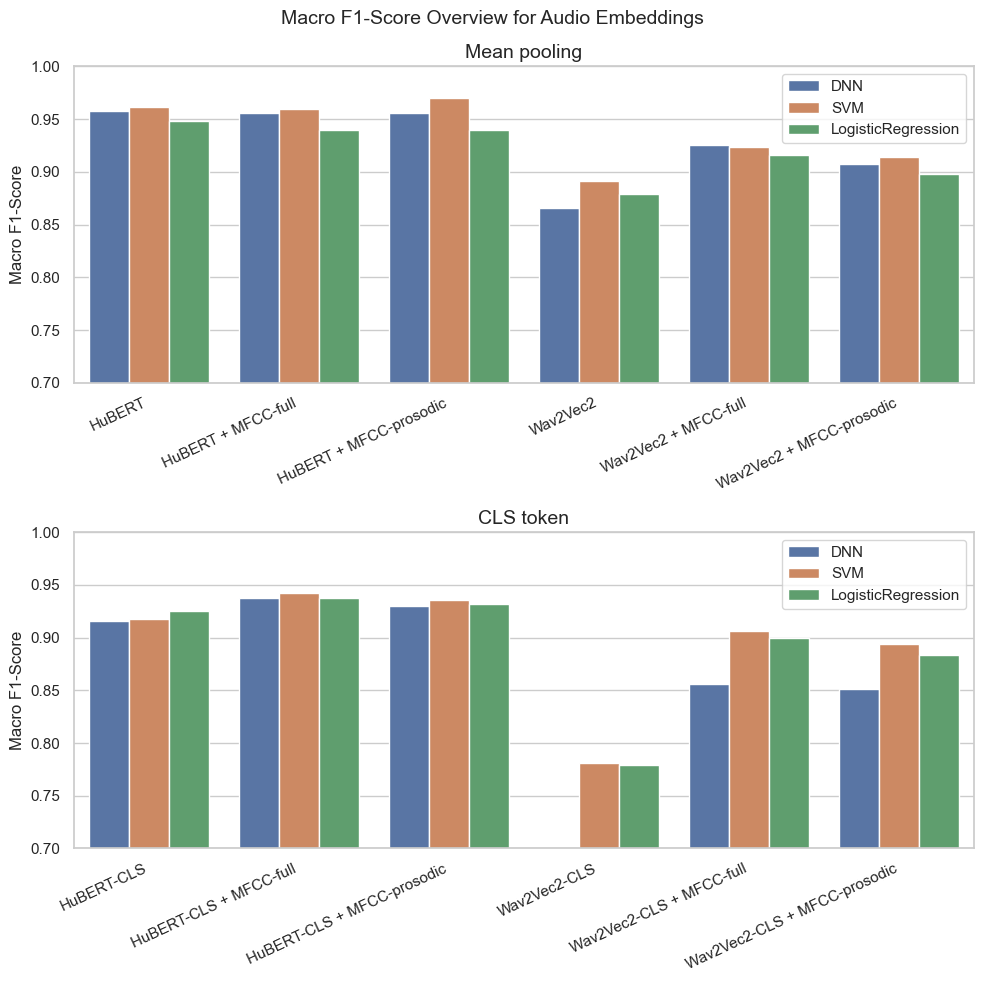

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [114]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plot_f1_overview(
    audio[(audio.name.str.contains("-mean", case=False)) &
          (~audio.name.str.contains("-stats", case=False)) &
          (audio.model != "RandomForest")]
        .apply(lambda x: x.str.replace("-Mean", "") if x.name == "name" else x)
        .apply(lambda x: x.str.replace("_", " + ") if x.name == "name" else x)
        .sort_values("name"),
    "Mean pooling",
    xticks_rotation=25,
    ax=axes[0],
)
plot_f1_overview(
    audio[(audio.name.str.contains("-cls", case=False)) &
          (~audio.name.str.contains("-stats", case=False)) &
          (audio.model != "RandomForest")]
        .apply(lambda x: x.str.replace("-cls", "") if x.name == "name" else x)
        .apply(lambda x: x.str.replace("_", " + ") if x.name == "name" else x)
        .sort_values("name"),
    "CLS token",
    xticks_rotation=25,
    ax=axes[1],
)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.suptitle("Macro F1-Score Overview for Audio Embeddings", fontsize=14)
fig.tight_layout()
fig.savefig("./WorkingNotes/figures/mono_audio.png", dpi=300)
plt.show()

In [ ]:
# Diferencias entre modelos

audio["base"] = audio["name"].apply(lambda x: "hubert" if "hubert" in x.lower() else "w2v2")
audio["token"] = audio["name"].apply(lambda x: "cls" if "cls" in x.lower() else "mean")
scores = audio.groupby(["base", "token"])["f1score"].mean().reset_index()
dif_hub = scores.query("base=='hubert' and token== 'mean'")["f1score"].values[0] - \
scores.query("base=='hubert' and token== 'cls'")["f1score"].values[0]
dif_mean = scores.query("base=='hubert' and token== 'mean'")["f1score"].values[0] - \
scores.query("base=='w2v2' and token== 'mean'")["f1score"].values[0]
dif_cls = scores.query("base=='hubert' and token== 'cls'")["f1score"].values[0] - \
scores.query("base=='w2v2' and token== 'cls'")["f1score"].values[0]
dif_hub, dif_mean, dif_cls

(np.float64(0.030837104915826474),
 np.float64(0.04640276763071782),
 np.float64(0.08133426780444053))

In [152]:
scores

,base,token,f1score
0,hubert,cls,0.910955
1,hubert,mean,0.941792
2,w2v2,cls,0.829620
3,w2v2,mean,0.895389


<Axes: title={'center': 'Combinated embeddings classification'}, ylabel='Macro F1-Score'>

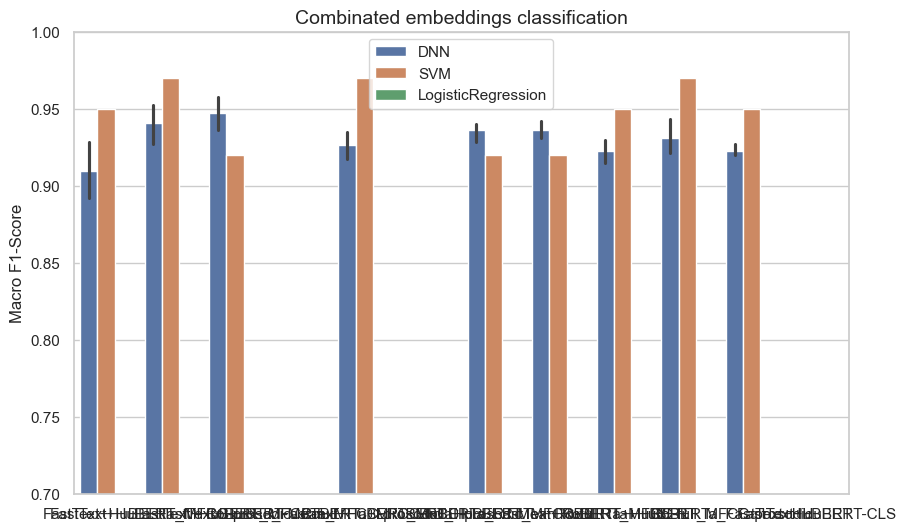

In [157]:
plot_f1_overview(
    combi[combi.model != "RandomForest"],
    "Combinated embeddings classification",
)

## Error Exploration

Lets analyze the common errors that occur with the best performing models when predicting the labels of the training set, using 
a training set of size 5500 and a holdout set for validation of 500 samples.

In [19]:
from pathlib import Path
import json

misses_dir = Path("results/misses")
misses: dict[str, set[str]] = dict()
for file in misses_dir.glob("*.json"):
    with open(file, "r") as f:
        misses[file.stem] = set(json.load(f)["ids_with_errors"])
    
common_misses = list(set.intersection(*misses.values()))
common_misses

['ab2e18c4-0100df14', '5b97747c-a4aca1b4']

In [ ]:
import os

common_misses_df = df[df["id"].isin(c + ".mp3" for c in common_misses)].reset_index(drop=True)
print(common_misses_df.iloc[0]["id"]+ ":\n", common_misses_df.iloc[0]["transcription"])
print(common_misses_df.iloc[1]["id"] + ":\n", common_misses_df.iloc[1]["transcription"])

# Open the audio files in the default system audio player
for idx in common_misses[1:]:
    audio_path = (data_path / "segments_train" / idx).with_suffix(".mp3")
    os.system(f"open {audio_path}")

ab2e18c4-0100df14.mp3:
 O de... Exacto, pero bueno. Así es las cosas y bueno, van a seguir con estos careos y van a seguir con el juicio donde le piden 200 millones de pesos a Carlos Loret por un video que injustamente puso en donde se ve al hermano del presidente recibiendo sobres de dinero. Va a haber un corte comercial y regresa. Ustedes, hermanita, no se muevan porque pasó todavía más cosa.
5b97747c-a4aca1b4.mp3:
 ¿Cómo se consigue que un niño sonría? Pues con una consola que es carísima. Pero, ¿opina lo mismo en un barrio rico que en un barrio obrero? ¿Piensan como yo que el dinero da la felicidad? Según dos premios Nobel en Economía, dicen que para ser feliz hay que ganar 100.000 euros al año. Teniendo en cuenta ese dato de 100.000 euros al año, ¿es usted feliz?


There are two samples in the dataset that every model fails to classify correctly, which are both classified as `no-satire` by our models: 

- `ab2e18c4-0100df14`: it seems like a segment from a TV show, where they talk about politics and corruption, using satire to talk about how the video was posted "injustifiedly". The speaker is a man, with a marked latino accent, and the audio starts with laughts and onomatopoeias that are not present in the transcription.
- `5b97747c-a4aca1b4`: it is a segment from a spanish TV show called _"El Intermedio"_, and the speaker, _"Thais Villas Aribau"_, a woman with a neutral castilian accent, is talking about how some nobel prize winners say that "to be happy you have to win 100k € per year". The audio starts with a comic comentary about how you can make a child happy by buying him an expensive console, which is specially notable in the audio and how it sounds like a joke. The context of the kind of TV show and its political content makes us think that the speaker also uses irony to express it's disagreement with the nobel prize winners.

In both cases it seems like the key to understand the usage of satire in the samples are hidden in the audio.

In [116]:
# Misses of the best performing model

bpm_miss_path = misses_dir / "SVM+roberta+hubert-mean_mfcc-prosodic+concat.json"
bpm_miss_path.exists()
bpm_misses = json.load(bpm_miss_path.open())["ids_with_errors"]

In [ ]:

for id in bpm_misses:
    transcription = df[df["id"] == id+ ".mp3"]["transcription"].values[0]
    label = df[df["id"] == id+ ".mp3"]["label"].values[0]
    print(f"{id} - {label}: \n {transcription}")
    audio_path = (data_path / "segments_train" / id).with_suffix(".mp3")
    os.system(f"open {audio_path}")

There where a total of 9 misses in the holdout set of 500 samples. Two of them are originaly classified as `no-satire`, and the other 7 are classified as `satire`. The following are the ids of the samples:

- `3db0b886-434a22fd` (no satírico): se trata de un segmento de un informativo de un canal de televisión latino, con un acento neutro poco marcado, en el que el presentador habla a cerca de unas declaraciones realizadas por Barack Obama. De fondo se escucha la típica música de fondo de muchos informativos, y finaliza con un efecto de sonido brusco. 
- `8f7e5f21-d3edaf72` (satírico): se trata de un segmento de _El Mundo Today_, un conocido medio de comunicación español en el que se dan noticias falsas como si estas fueran reales en un tono marcadamente satírico e irónico. El audio contiene también sonido de fondo típico de informativos serios, y el tono de la presentadora, castellano con acento neutro, es totalmente serio. La clave para detectar la sátira reside en el contexto de lo que se comenta en el él, ya que el resto es prácticamente indistinguible de un informativo formal.
- `e29b87d0-628166cf` (satírico): como el anterior, pero se intercala la intervención de la presentadora del programa con la intervención de un corresponsal, también con un acento castellano neutro y un tono serio de informativo. Como en el anterior, la clave para detectar la sátira reside en el contexto de lo que se comenta en el él, ya que el resto es prácticamente indistinguible de un informativo formal.
- `607a93b9-4a3b098e` (satírico): es un segmento de un conocido programa de televisión de España llamado _El Intermedio_, donde el presentador, _El Gran Wyoming_, está haciendo una especie de declaración editorial sobre la tauromaquia. El audio comienza con risas del público, y contiene el mismo efecto de sonido de fondo que venimos describiendo en el resto de observaciones. El tono del presentador mezcla seriedad al principio del audio con un tono más burlesco hacia el final, donde utiliza la sátira para ridiculizar la tauromaquia.
- `ca6bda3a-3cfca4c5` (satírico): en este segmento de un programa de televisión latino en el que se habla de actualidad política, el presentador, con un marcado acento latino, utiliza un tono exagerado incluyendo golpes en la mesa para expresar su frustración con el tema del que se habla, en este caso, corrupción política y nepotismo. El audio carece del sonido de fondo característico de los informativos comentado anteriormente.
- `ab2e18c4-0100df14` (satírico): se trata de un segmento de un programa de televisión en el que se habla de actualidad política de forma jocosa e informal. El presentador, con un marcado acento latino, comienza su intervención con risas y onomatopeyas que no están presentes en la transcripción.
- `e1a1a563-73ebf7f1` (satírico): se trata de un segmento de lo que podría parecer una entrevista en un medio distendido, con un formato típico de redes sociales, con una música de fondo típica de reels y shorts, mucho más marcada que en el caso de los informativos. Por su contenido, no se consigue identificar si se trata de sátira o no, ya que haría falta contexto de quién y cómo realiza las declaraciones, aunque en principio parecería que nos equivocamos al etiquetar la observación y podría ser no-satírica.
- `5b97747c-a4aca1b4` (satírico): es un segmento de un conocido programa de televisión de España llamado _El Intermedio_, y la hablante, _Thais Villas Aribau_, una mujer con acento castellano neutro, habla sobre cómo algunos ganadores de la Nobel afirman que "para ser feliz, tienes que ganar 100.000€ al año". El audio comienza con un comentario cómico sobre cómo puedes hacer feliz a un niño comprandole un consola cara, que es especialmente notable en el audio por la entonación de la presentadora. El contexto del tipo de programa de televisión y su contenido político nos permiten saber que el hablante también utiliza ironía para expresar su desacuerdo con los ganadores de la Nobel.
- `eebdb176-23f41919` (no satírico): se trata de un segmento de informativos de un canal de televisión latino, con un acento neutro poco marcado, en el que el presentador habla sobre una resolución de la corte internacional de la Haya, con un tono completamente monótono y serio. De fondo se escucha la típica música de fondo de muchos informativos que hemos analizado aquí. 

In [117]:
id = bpm_misses[0]
transcription = df[df["id"] == id+ ".mp3"]["transcription"].values[0]
label = df[df["id"] == id+ ".mp3"]["label"].values[0]
print(f"{id} - {label}: \n {transcription}")
audio_path = (data_path / "segments_train" / id).with_suffix(".mp3")
os.system(f"open {audio_path}")

3db0b886-434a22fd - no-satire: 
 El presidente de Estados Unidos, Barack Obama, prometió un año de acción con el fin de revertir la desigualdad social e impulsar la economía en su país. Durante su discurso sobre el Estado de la Unión, Obama también defendió su programa de salud y dijo que Estados Unidos debe dejar de estar en pie de guerra.


NameError: name 'os' is not defined